In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Preparing data

**Make sure that you have the data placed in `Data` folder**. The next asserts should pass correctly.

In [3]:
RAW_PATH = 'initial_data' # Folder with class folders

In [4]:
import os
assert os.path.exists(RAW_PATH)

Let's prepare the data now!

In [5]:
PATH = 'data' # where the images will be stored in a good way for the identifier

In [6]:
!rm -rf data

In [7]:
import pickle
from cv.identification.utils import reorganize_folder2

tagged, inverse_mapping = reorganize_folder2(RAW_PATH, PATH, extension='.jpg', verbose=True)

In [8]:
names = list(filter(lambda x: '.jpg' in x, sorted(os.listdir('data'))))
classes = [tagged[name] for name in names]

Splitting into train/test:

In [9]:
from sklearn.model_selection import train_test_split
train_names, test_names = train_test_split(names, test_size=0.2, random_state=42, stratify=classes)

In [10]:
from cv.identification.data_manager import DataManager

def dictify(initial_dict, names):
    result = dict()
    for name in names:
        result[name] = initial_dict[name]
    return result

train_manager = DataManager(train_names, dictify(tagged, train_names), train=True)
test_manager = DataManager(test_names, dictify(tagged, test_names), train=False)

# 2. Training in Grayscale

We'll use `ImgReader` as a convenience class to read images from disk:

In [38]:
from cv.identification.io import ImgReader
IMG_SHAPE = (256, 256, 1) # Later we'll use (256, 256, 3) for RGB training
reader = ImgReader(IMG_SHAPE, paths=[PATH])

Let's see what it can do!

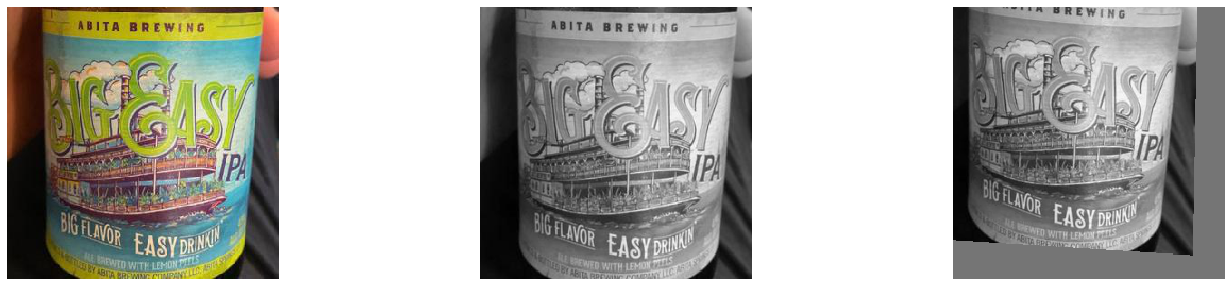

In [25]:
from keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt

def show_beers(imgs, per_row=2):
    n = len(imgs)
    if n == 1:
        plt.figure(figsize=(14, 4))
        plt.axis('off')
        plt.imshow(img_reader.read_raw(imgs[0]))
        plt.show()
        return
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24 // per_row * cols, 16 // per_row * rows))
    for ax in axes.flatten():
        ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())):
        ax.imshow(img.convert('RGB'))

p = train_names[0]
imgs = [
    reader.read_raw(p),
    array_to_img(reader.read_for_validation(p)),
    array_to_img(reader.read_for_training(p))
]

show_beers(imgs, per_row=3)

The `TrainingData` class is responsible for generating same/different pairs of beers:

In [35]:
import numpy as np
from cv.identification.siamese.generators import TrainingData

score = np.random.random_sample(size=(len(train_manager),len(train_manager)))
data = TrainingData(score, train_manager, reader)
(a, b), c = data[0]
a.shape, b.shape, c.shape
imgs = [array_to_img(a[0]), array_to_img(b[0])]

Solving LAP...
20 errors
Ended solving LAP.


Example of a training pair **of a same pair of beers**:

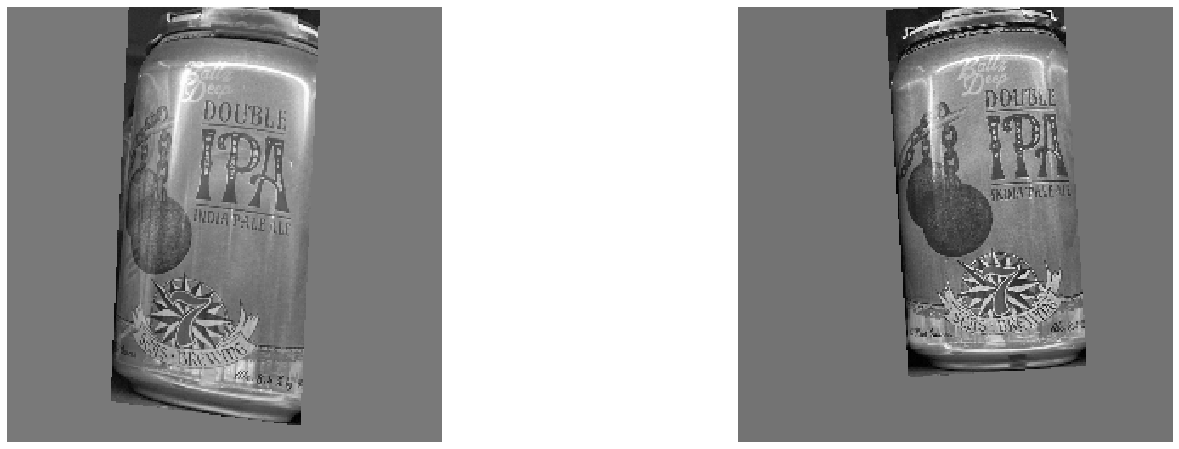

In [36]:
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_beers(imgs)

Example of a training pair **of a different pair of beers**:

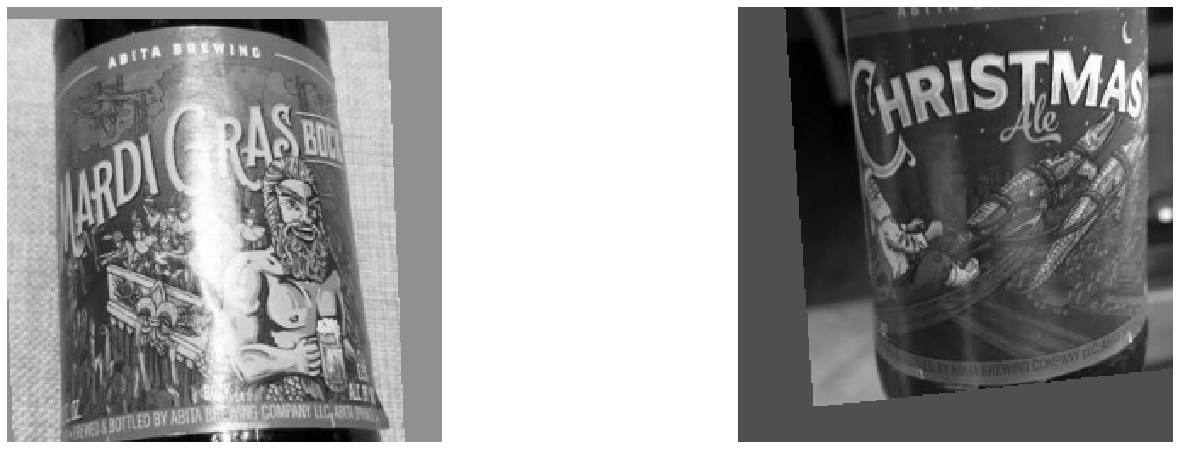

In [37]:
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_beers(imgs)

Now, let's build a model!

In [41]:
from cv.identification.siamese.nets import create_branch, create_head, create_siamese
branch_model = create_branch(IMG_SHAPE, 0.0)
head_model = create_head(branch_model.output_shape)
model = create_siamese(branch_model, head_model, 64e-5)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Everything is now ready for training.

In [55]:
model_name = 'model_3.256.tutorial'

In [52]:
from cv.identification.siamese.training import Trainer
trainer = Trainer(model, model_name, reader, train_manager, test_manager, verbose=True)

Main training pipeline:

In [54]:
amplitude = 100

for i in range(10):
    trainer.train(64e-5, amplitude, num_blocks=1, steps_per_block=5)
    amplitude = amplitude ** (-0.1)

trainer.train(16e-5, 0.5, 4, 5)
trainer.train(4e-5, 0.25, 3, 5)
trainer.train(4e-5, 0.15, 2, 5)
trainer.train(1e-5, 0.1, 2, 5)

Saving the model:

In [56]:
trainer.model.save(f'{model_name}.hdf5')

Let's evaluate the model once again:

In [57]:
from cv.identification.siamese.utils import evaluate_accuracy

In [59]:
evaluate_accuracy(trainer.branch_model, trainer.head_model, test_manager, train_manager, reader)

# 3. Retraining on RGB

In [11]:
from keras.models import load_model
model = load_model('model_3.256.hdf5')

Using TensorFlow backend.
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/p

/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [15]:
from cv.identification.siamese.nets import *
from cv.identification.siamese.utils import *
branch_model, head_model = parse_model(model)

First, we need to create a model with RGB inputs. Luckily, that's very easy to do.

In [16]:
branch_rgb = create_branch((256, 256, 3), 0.0)

Now, let's transfer all the weights, except for the first layer:

In [17]:
import tqdm
for i in tqdm.tqdm_notebook(range(len(branch_model.layers))):
    if i == 1:
        continue
    branch_rgb.layers[i].set_weights(branch_model.layers[i].get_weights())

/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Freezing the model weights for all the layers except for the last one:

In [18]:
for i in range(2, len(branch_rgb.layers)):
    branch_rgb.layers[i].trainable = False
    
for i in range(len(head_model.layers)):
    head_model.layers[i].trainable = False

In [19]:
rgb_model = create_siamese(branch_rgb, head_model, 64e-5)

In [20]:
rgb_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512)          2702464     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
head (Model)                    (None, 1)            706         model_2[1][0]              

As you can see, the number of training parameters is very small. That's because we are essentially just training the first layer for now:

In [23]:
from cv.identification.io import ImgReader
IMG_SHAPE = (256, 256, 3)
reader = ImgReader(IMG_SHAPE, paths=[PATH])

from cv.identification.siamese.training import Trainer
trainer = Trainer(rgb_model, 'model_4.256.rgb', reader, train_manager, test_manager, True)

In [25]:
trainer.train(64e-5, 4, 1, 2) # Just 2 epochs!

In [26]:
trainer.model.save('model_4.256.base.hdf5')

Now, in order to further train in RGB, all we have to do is to load the model (using `keras.load_model`, define the reader with `IMG_SHAPE = (256, 256, 3)` and train with the same schedule as of a grayscale model once again. This should be very straightforward.

# 3. Generating index file

In [27]:
names = train_names + test_names

In [28]:
from cv.identification.data_manager import DataManager
all_manager = DataManager(names, tagged)

In [29]:
reader = ImgReader((256, 256, 3), paths=['data'])
model = load_model('model_4.flip_lr.hdf5')
branch_model, head_model = parse_model(model)

features = branch_model.predict_generator(FeatureGen(all_manager, reader, verbose=True), max_queue_size=16, workers=12, verbose=0)

In [30]:
from collections import defaultdict
cls2vecs = defaultdict(list)
for i in range(len(features)):
    item = all_manager.items[i]
    cls = all_manager.tagged[item]
    cls2vecs[cls].append(features[i])

classes_ = sorted(list(cls2vecs.keys()))
classes = []
means = []
for cls in classes_:
    classes.append(cls)
    means.append(np.mean(cls2vecs[cls], axis=0))

In [31]:
f = open('classes_4.flip_lr.txt', 'w')
for cls in classes:
    f.write(cls + '\n')
f.close()

In [32]:
f = open('vectors_4.flip_lr.txt', 'w')
for vec in means:
    f.write(' '.join(map(str, vec)) + '\n')
f.close()